In [66]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import StandardScaler , label_binarize


In [67]:

# Function to load the dataset from local files (binary files)
def load_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
        return images

def load_mnist_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


In [68]:
# Load the datasets from local files
train_images = load_mnist_images('train-images-idx3-ubyte')
train_labels = load_mnist_labels('train-labels-idx1-ubyte')
test_images = load_mnist_images('t10k-images-idx3-ubyte')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte')

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)



Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [69]:
# Keep only the first 5 classes
train_images = train_images[train_labels < 5]
train_labels = train_labels[train_labels < 5]
test_images = test_images[test_labels < 5]
test_labels = test_labels[test_labels < 5]

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Flatten the images for KNN
train_images = train_images.reshape(-1, 28*28)
test_images = test_images.reshape(-1, 28*28)

In [70]:
# Apply scaling for KNN
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)


In [71]:
# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_images, train_labels)

# Predict the labels for the test set
test_predictions = knn.predict(test_images)


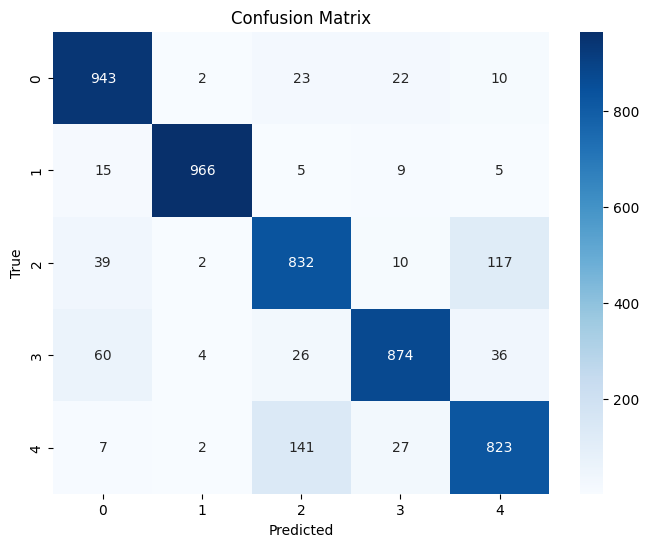

In [72]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(5), yticklabels=np.arange(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [73]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Precision, Recall, and F1 Score
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Accuracy: 88.76%
Precision: 0.89
Recall: 0.89


In [74]:
# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(test_labels, classes=[0, 1, 2, 3, 4])
y_pred_proba = knn.predict_proba(test_images)

<Figure size 1000x800 with 0 Axes>

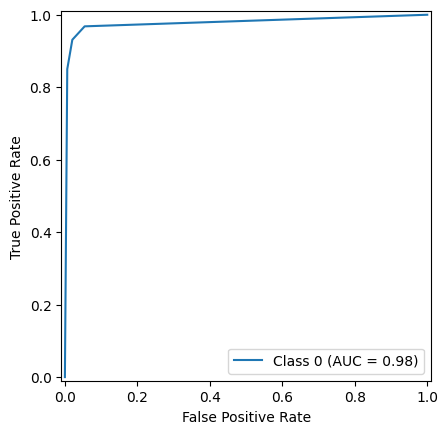

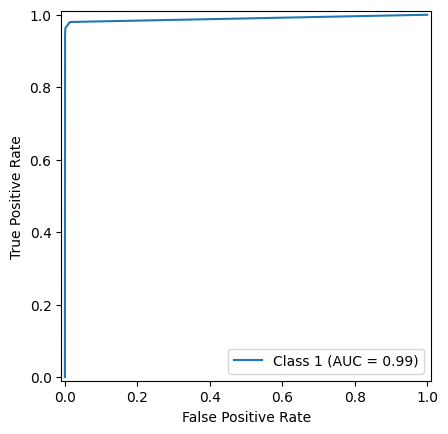

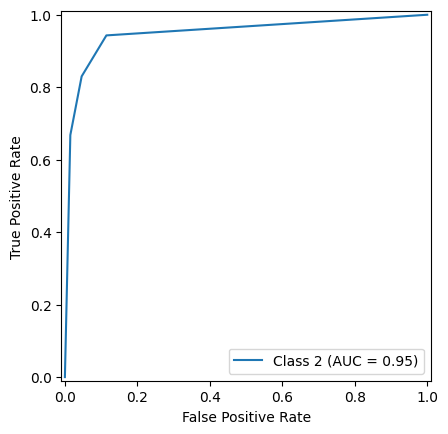

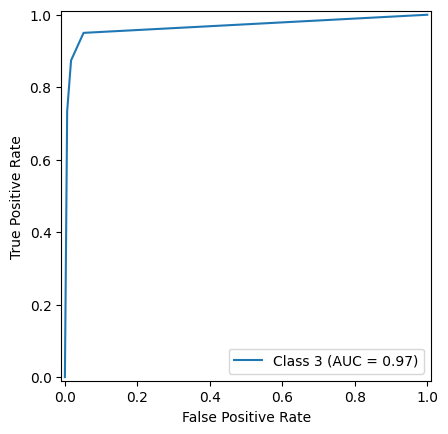

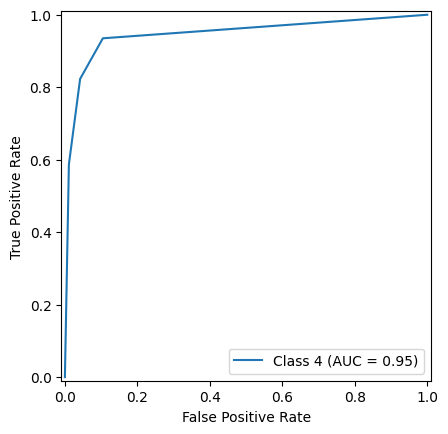

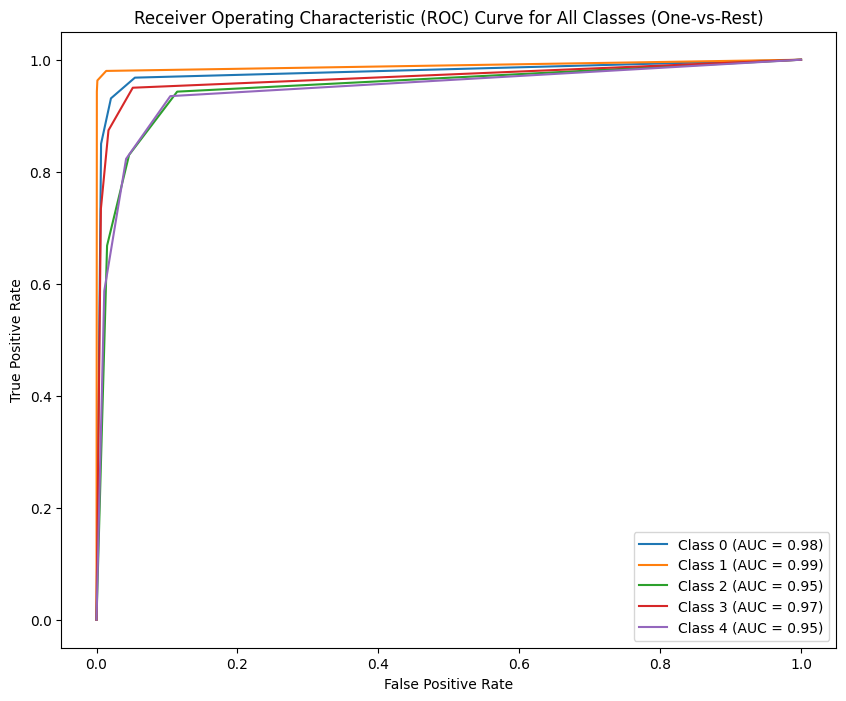

In [75]:
# Initialize variables to store AUC and Recall for each class
auc_values = []
recall_values = []

# Set up the plot for individual ROC curves
plt.figure(figsize=(10, 8))

# Iterate over all classes to generate individual ROC curves
for i in range(5):  # Assuming 5 classes, adjust if different
    # Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    
    # Compute AUC
    roc_auc = auc(fpr, tpr)
    auc_values.append(roc_auc)
    
    # Compute Recall directly from predictions
    y_true = y_test_bin[:, i]
    y_pred_class = (y_pred_proba[:, i] >= 0.5).astype(int)  # Apply a threshold of 0.5
    true_positive = np.sum((y_pred_class == 1) & (y_true == 1))
    false_negative = np.sum((y_pred_class == 0) & (y_true == 1))
    recall_at_threshold = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    recall_values.append(recall_at_threshold)
    
    # Plot ROC curve for each class
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random guessing) for individual curves
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing')

# Customize the plot for individual curves
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Display the plot for individual ROC curves
plt.show()

# Set up the plot for combined ROC curve (One-vs-Rest)
plt.figure(figsize=(10, 8))

# Initialize variables for combined ROC curve (One-vs-Rest)
fpr_all = {}
tpr_all = {}
roc_auc_all = {}

# Compute combined ROC curve (One-vs-Rest)
for i in range(5):  # Assuming 5 classes
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc_all[i] = auc(fpr, tpr)
    
    # Plot ROC curve for each class in combined plot
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_all[i]:.2f})')

# Plot the diagonal line (random guessing) for combined curve
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing')

# Customize the plot for combined curves
plt.title('Receiver Operating Characteristic (ROC) Curve for All Classes (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Display the plot for combined ROC curves
plt.show()


In [76]:

# Print AUC and Recall for each class
for i in range(5):
    print(f"Class {i}: AUC = {auc_values[i]:.2f}, Recall (at threshold 0.5) = {recall_values[i]:.2f}")


Class 0: AUC = 0.98, Recall (at threshold 0.5) = 0.93
Class 1: AUC = 0.99, Recall (at threshold 0.5) = 0.96
Class 2: AUC = 0.95, Recall (at threshold 0.5) = 0.83
Class 3: AUC = 0.97, Recall (at threshold 0.5) = 0.87
Class 4: AUC = 0.95, Recall (at threshold 0.5) = 0.82


In [77]:

# Compute and print the averages
average_auc = np.mean(auc_values)
average_recall = np.mean(recall_values)
print(f"Average AUC = {average_auc:.2f}")
print(f"Average Recall (at threshold 0.5) = {average_recall:.2f}")


Average AUC = 0.97
Average Recall (at threshold 0.5) = 0.88


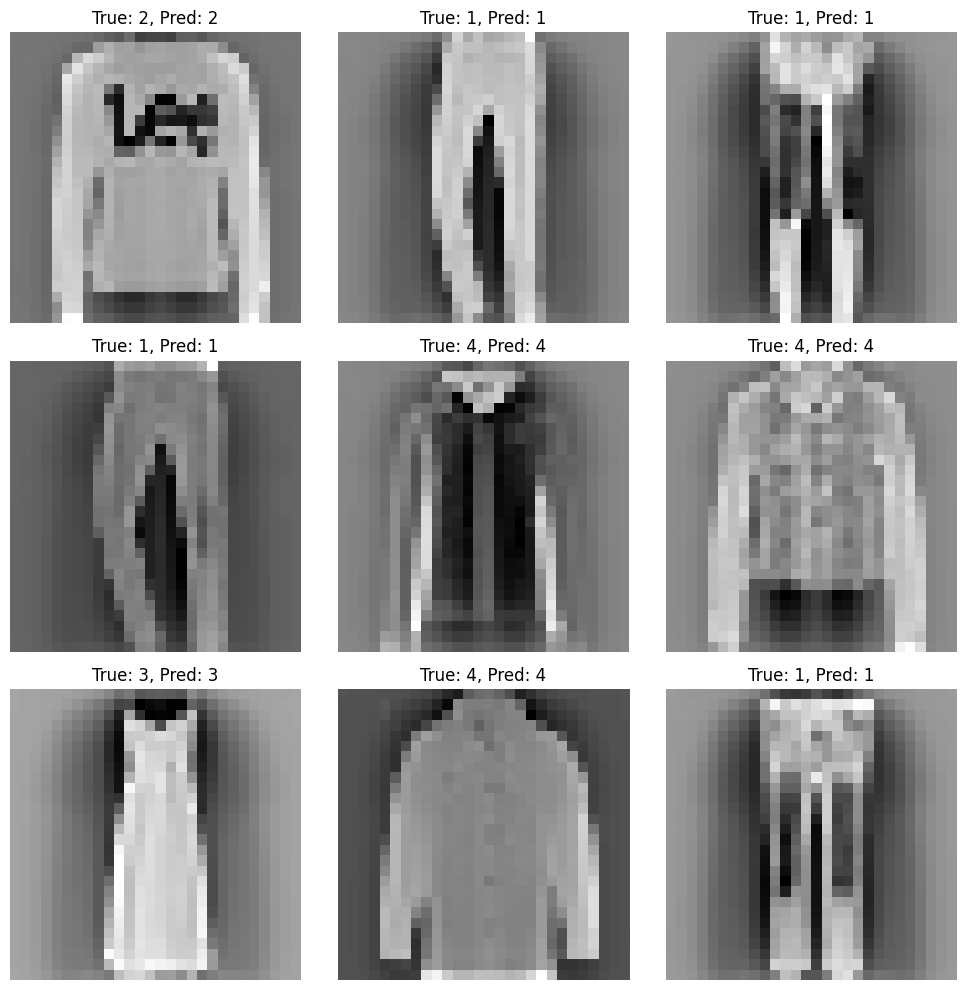

In [78]:
# Visualize a few test set predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {test_labels[i]}, Pred: {test_predictions[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()